In [1]:
!python -V

Python 3.11.13


In [2]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pickle

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [5]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [6]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-02.parquet')

In [7]:
len(df_train), len(df_val)

(59603, 66097)

In [8]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [9]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

8.193832538879942

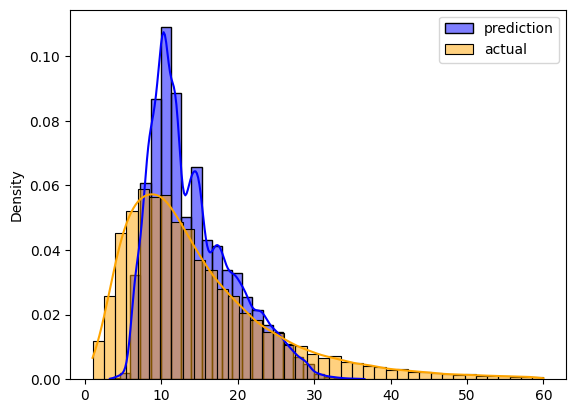

In [11]:
sns.histplot(y_pred, kde=True, stat="density", color='blue', bins=25, label='prediction')
sns.histplot(y_val, kde=True, stat="density", color='orange', bins=40, label='actual')

plt.legend()

In [12]:
with open('lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [13]:
import mlflow 

In [14]:
mlflow.set_tracking_uri("http://mlflow:5000")
mlflow.set_experiment("nyc-taxi-experiment")


<Experiment: artifact_location='file:///mlflow/artifacts/2', creation_time=1760020712437, experiment_id='2', last_update_time=1760020712437, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
from sklearn.pipeline import make_pipeline

In [17]:
with mlflow.start_run():
    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']

    train_dicts = df_train[categorical + numerical].to_dict(orient='records')
    val_dicts = df_val[categorical + numerical].to_dict(orient='records')

    mlflow.log_params({
        'categorical': categorical,
        'numerical': numerical,
    })
    
    pipeline = make_pipeline(
        DictVectorizer(),
        LinearRegression()
    )
    
    pipeline.fit(train_dicts, y_train)
    y_pred = pipeline.predict(val_dicts)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(rmse)
    mlflow.log_metric('rmse', rmse)
    
    mlflow.sklearn.log_model(pipeline, 'model')

8.193832538879942


In [18]:
model = mlflow.pyfunc.load_model('models:/trip_duration/staging')

In [19]:
model.predict(val_dicts)

array([ 8.78925931,  9.86947754, 17.00952339, ..., 11.04561888,
       14.83815748, 26.41008024])

In [20]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "http://mlflow:5000"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [21]:
client.get_registered_model('trip_duration', )

<RegisteredModel: aliases={}, creation_timestamp=1760020819393, description='', last_updated_timestamp=1760020828626, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1760020819433, current_stage='Staging', description='', last_updated_timestamp=1760020828626, name='trip_duration', run_id='8aee7ba80cec4219af96004047dde777', run_link='', source='file:///mlflow/artifacts/2/8aee7ba80cec4219af96004047dde777/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>], name='trip_duration', tags={}>

In [22]:
client.search_registered_models("name='trip_duration'")

[<RegisteredModel: aliases={}, creation_timestamp=1760020819393, description='', last_updated_timestamp=1760020828626, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1760020819433, current_stage='Staging', description='', last_updated_timestamp=1760020828626, name='trip_duration', run_id='8aee7ba80cec4219af96004047dde777', run_link='', source='file:///mlflow/artifacts/2/8aee7ba80cec4219af96004047dde777/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>], name='trip_duration', tags={}>]

In [23]:
model_metadata = client.get_registered_model('trip_duration')

In [24]:
model_metadata

<RegisteredModel: aliases={}, creation_timestamp=1760020819393, description='', last_updated_timestamp=1760020828626, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1760020819433, current_stage='Staging', description='', last_updated_timestamp=1760020828626, name='trip_duration', run_id='8aee7ba80cec4219af96004047dde777', run_link='', source='file:///mlflow/artifacts/2/8aee7ba80cec4219af96004047dde777/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>], name='trip_duration', tags={}>